In [22]:
from datetime import datetime , timedelta , time , date
import learning_lidar.preprocessing.preprocessing as prep
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sns
from scipy.stats import multivariate_normal
import xarray as xr
from learning_lidar.utils.proc_utils import Bezier
import learning_lidar.utils.global_settings as gs
import learning_lidar.generation.generation_utils as gen_utils

gs.set_visualization_settings()

def valid_box_domain(x,y,bounds_x,bounds_y):
	return x>=bounds_x[0] and x<=bounds_x[1] and y>=bounds_y[0] and y<=bounds_y[1]

Kernel density estimation and sampling example

In [23]:
RUN_GENERAL = False
# General example for kde sampling
if RUN_GENERAL:
    def measure(n):
        "Measurement model, return two coupled measurements."
        m1 = np.random.normal(size=n)
        m2 = np.random.normal(scale=0.5, size=n)
        return m1+m2, m1-m2

    # Generate some random two-dimensional data:
    m1, m2 = measure(200)
    xmin = m1.min()
    xmax = m1.max()
    ymin = m2.min()
    ymax = m2.max()

    # Perform a kernel density estimate on the data:
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([m1, m2])
    kernel = stats.gaussian_kde(values)#,bw_method='silverman')
    Z = np.reshape(kernel(positions).T, X.shape)

    # Perform a resample from the estimated density of the data:
    [n1,n2] = kernel.resample(40,seed=1234)

    # Choose 30 points with best score
    scores_new = kernel(np.vstack([n1, n2]))
    ind = np.argpartition(scores_new, -30)[-30:]
    max_n1,max_n2 = n1[ind],n2[ind]

    # Plot the results:

    fig, ax = plt.subplots()
    im = ax.imshow(np.rot90(Z), cmap='turbo',# plt.cm.gist_earth_r,
              extent=[xmin, xmax, ymin, ymax])
    ax.plot(m1, m2, 'k+', markersize=5)
    #ax.plot(n1, n2, 'm+', markersize=3)
    ax.plot(max_n1, max_n2, 'k*', markersize=6)
    ax.plot(max_n1, max_n2, 'w*', markersize=4)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    fig.colorbar(im, ax=ax)
    plt.show()

## Set station and date parameters
 - Load measurements from AERONET for current month

In [24]:
station = gs.Station('haifa')
wavelengths = gs.LAMBDA_nm().get_elastic()
folder_name = station.aeronet_folder

month = 10
year = 2017
monthdays = (date(year,month+1,1)-date(year,month,1)).days
start_day = datetime(year,month,1,0,0)
end_day = datetime(year,month,monthdays,0,0)
nc_aeronet_name = f"{start_day.strftime('%Y%m%d')}_{end_day.strftime('%Y%m%d')}_{station.name}_ang.nc"
ds_ang = prep.load_dataset(os.path.join(folder_name,nc_aeronet_name))

## Angstrom Exponent
### $A_{355,532}$ vs. $A_{532,1064 }$ for the current month
1. Perform a kernel density estimation on the data

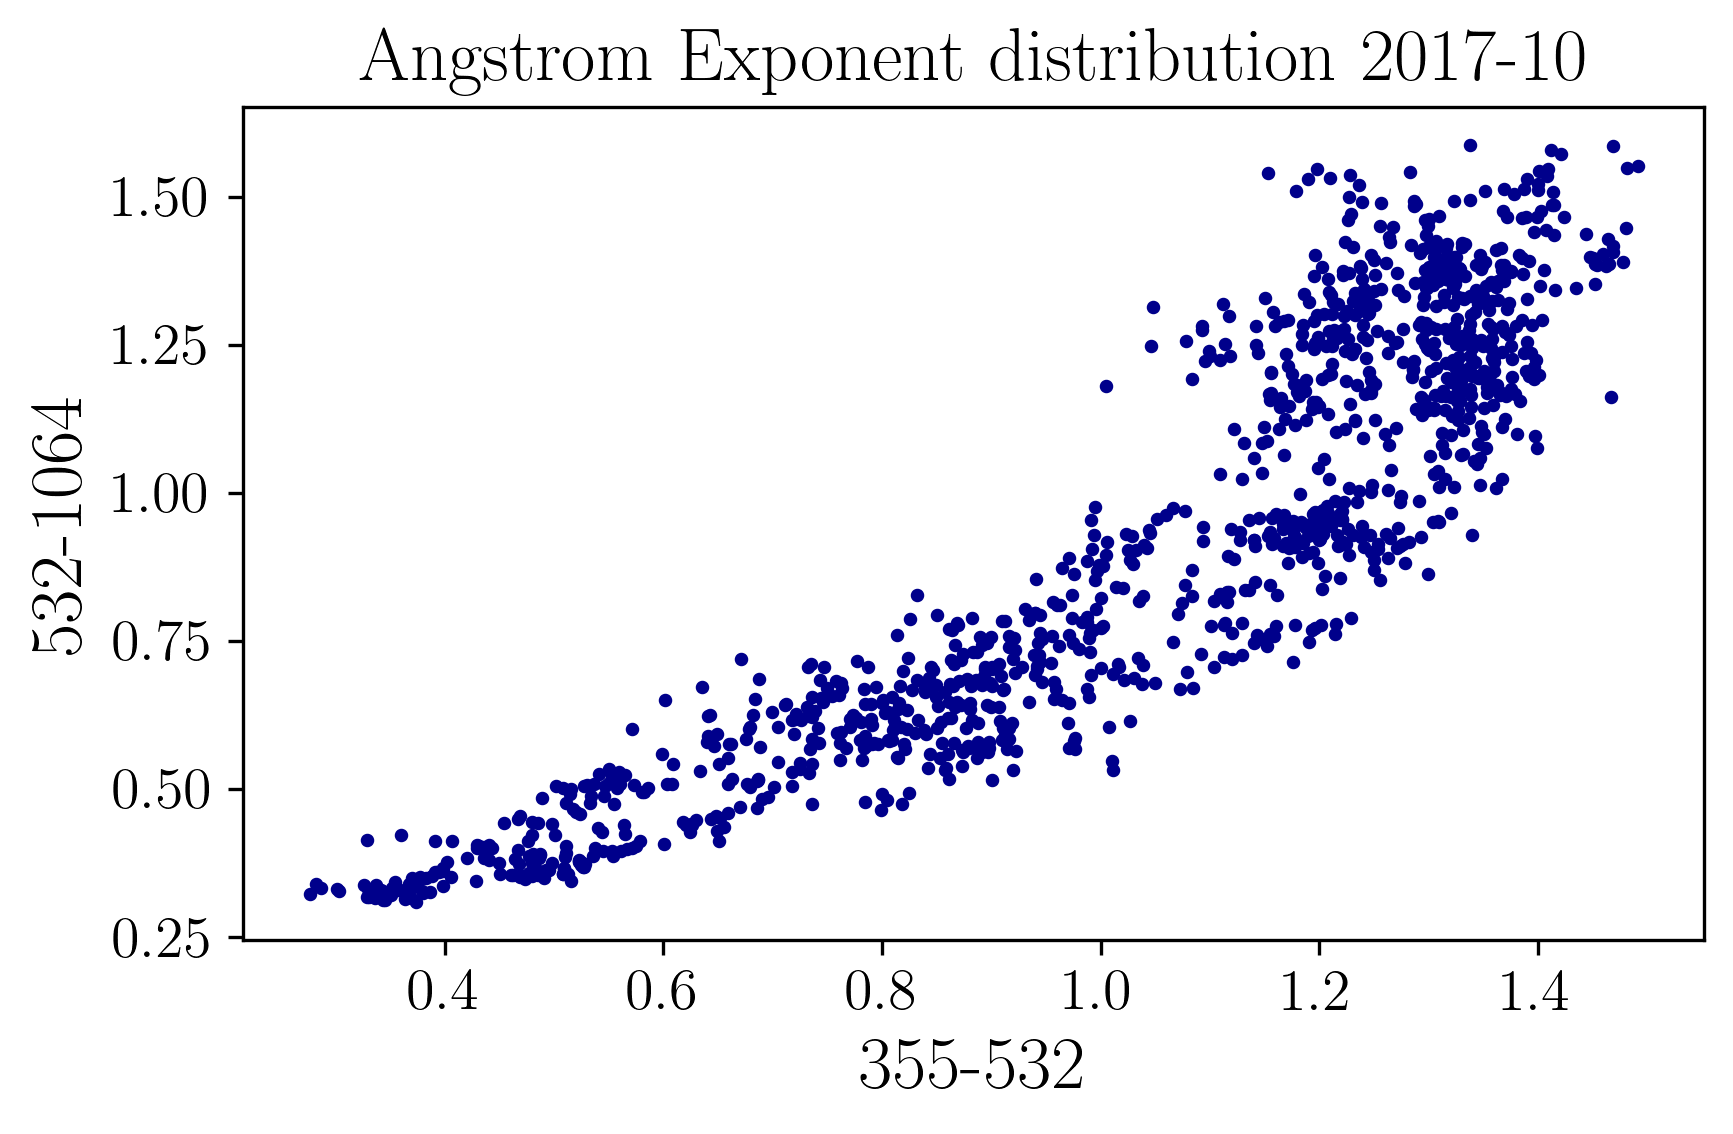

In [25]:
t_slice =slice(start_day,
               end_day+timedelta(days =1)-timedelta(seconds = 30))
couple_0 = f"{355}-{532}"
couple_1 = f"{532}-{1064}"
angstrom_daily = []

x = ds_ang.angstrom.sel(Wavelengths = couple_0).values
y = ds_ang.angstrom.sel(Wavelengths = couple_1).values

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(x=x,y=y,s=5)
ax.set_xlabel(couple_0)
ax.set_ylabel(couple_1)
ax.set_title(f"Angstrom Exponent distribution {t_slice.start.strftime('%Y-%m')}")
plt.tight_layout()
plt.show()

2. Perform a kernel density estimation on the data
3. Resample the estimated density generate new values for $A_{355,532}$ & $A_{532,1064 }$, per each day

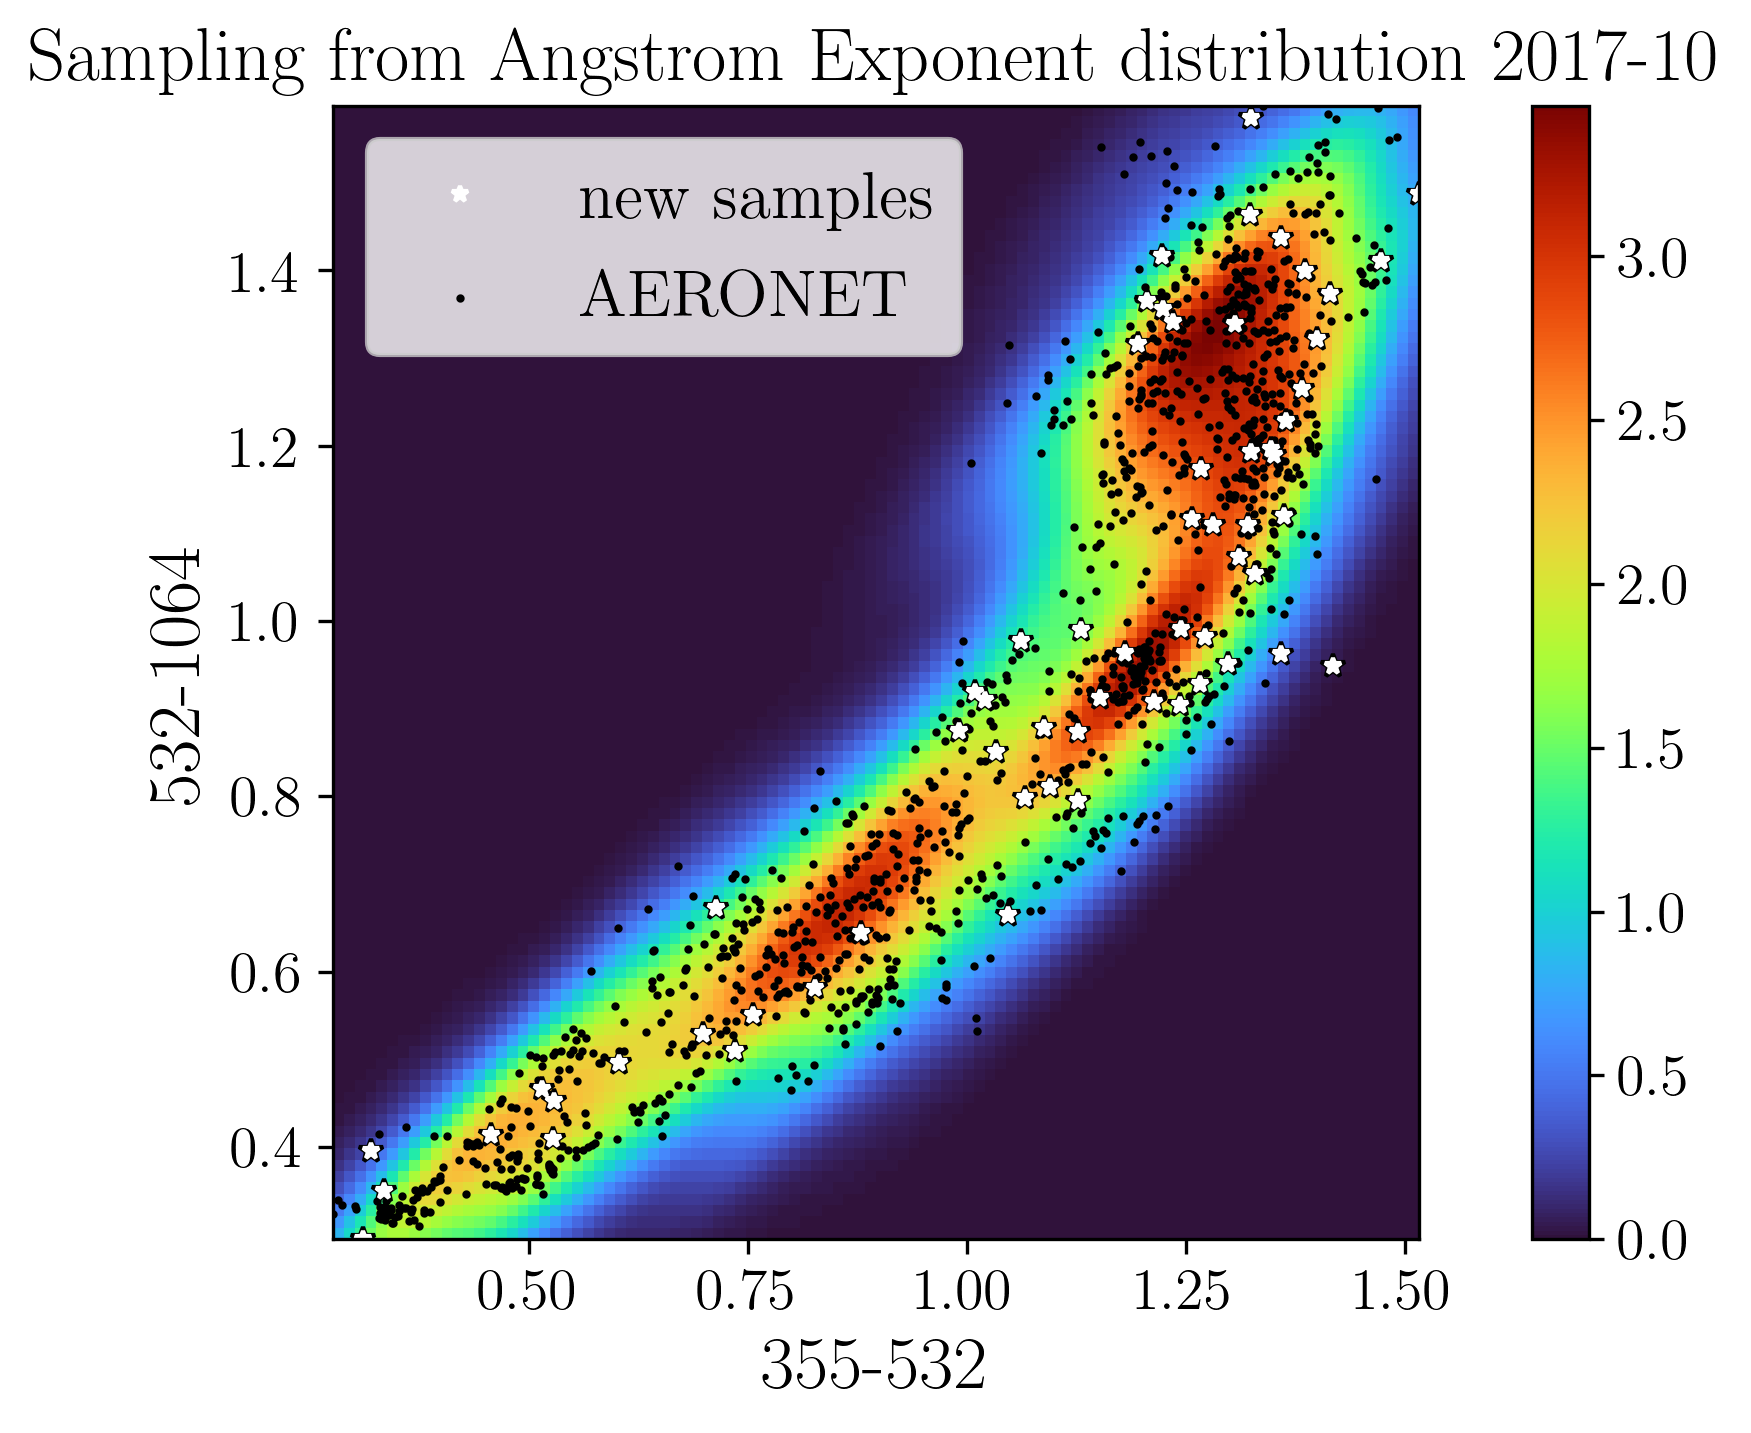

In [26]:
# Remove nan values
valid_ind = np.where( ~np.isnan(x) & ~np.isnan(y))[0] #or np.where(y==np.nan) # and y~np.nan)
x = x[valid_ind]
y = y[valid_ind]
values = np.vstack([x, y])

# Estimate kernel
kernel = stats.gaussian_kde(values)

# Sample new points
[x1,y1] = kernel.resample(2*monthdays)
scores_new = kernel(np.vstack([x1, y1]))
max_ind = np.argpartition(scores_new, -2*monthdays)[-2*monthdays:]
ang_355_532,ang_532_1064 = x1[max_ind],y1[max_ind]

# Calc 2D function of the density
xmin = min(x.min(),x1.min())
xmax = max(x.max(),x1.max())
ymin = min(y.min(),y1.min())
ymax = max(y.max(),y1.max())
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

# Show density and the new chosen samples
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (8,5))
ax.scatter(x=x,y=y,s=1,c='k',label ='AERONET')
im = ax.imshow(np.rot90(Z), cmap='turbo',
          extent=[xmin, xmax, ymin, ymax])
ax.plot(ang_355_532, ang_532_1064, 'k*', markersize=6)
ax.plot(ang_355_532, ang_532_1064, 'w*', markersize=4,label = 'new samples')
ax.set_xlabel(couple_0)
ax.set_ylabel(couple_1)
ax.set_title(f"Sampling from Angstrom Exponent distribution {t_slice.start.strftime('%Y-%m')}")
fig.colorbar(im, ax=ax)
plt.legend()
plt.tight_layout()
plt.show()

## Angsrom - Lidar Ratio

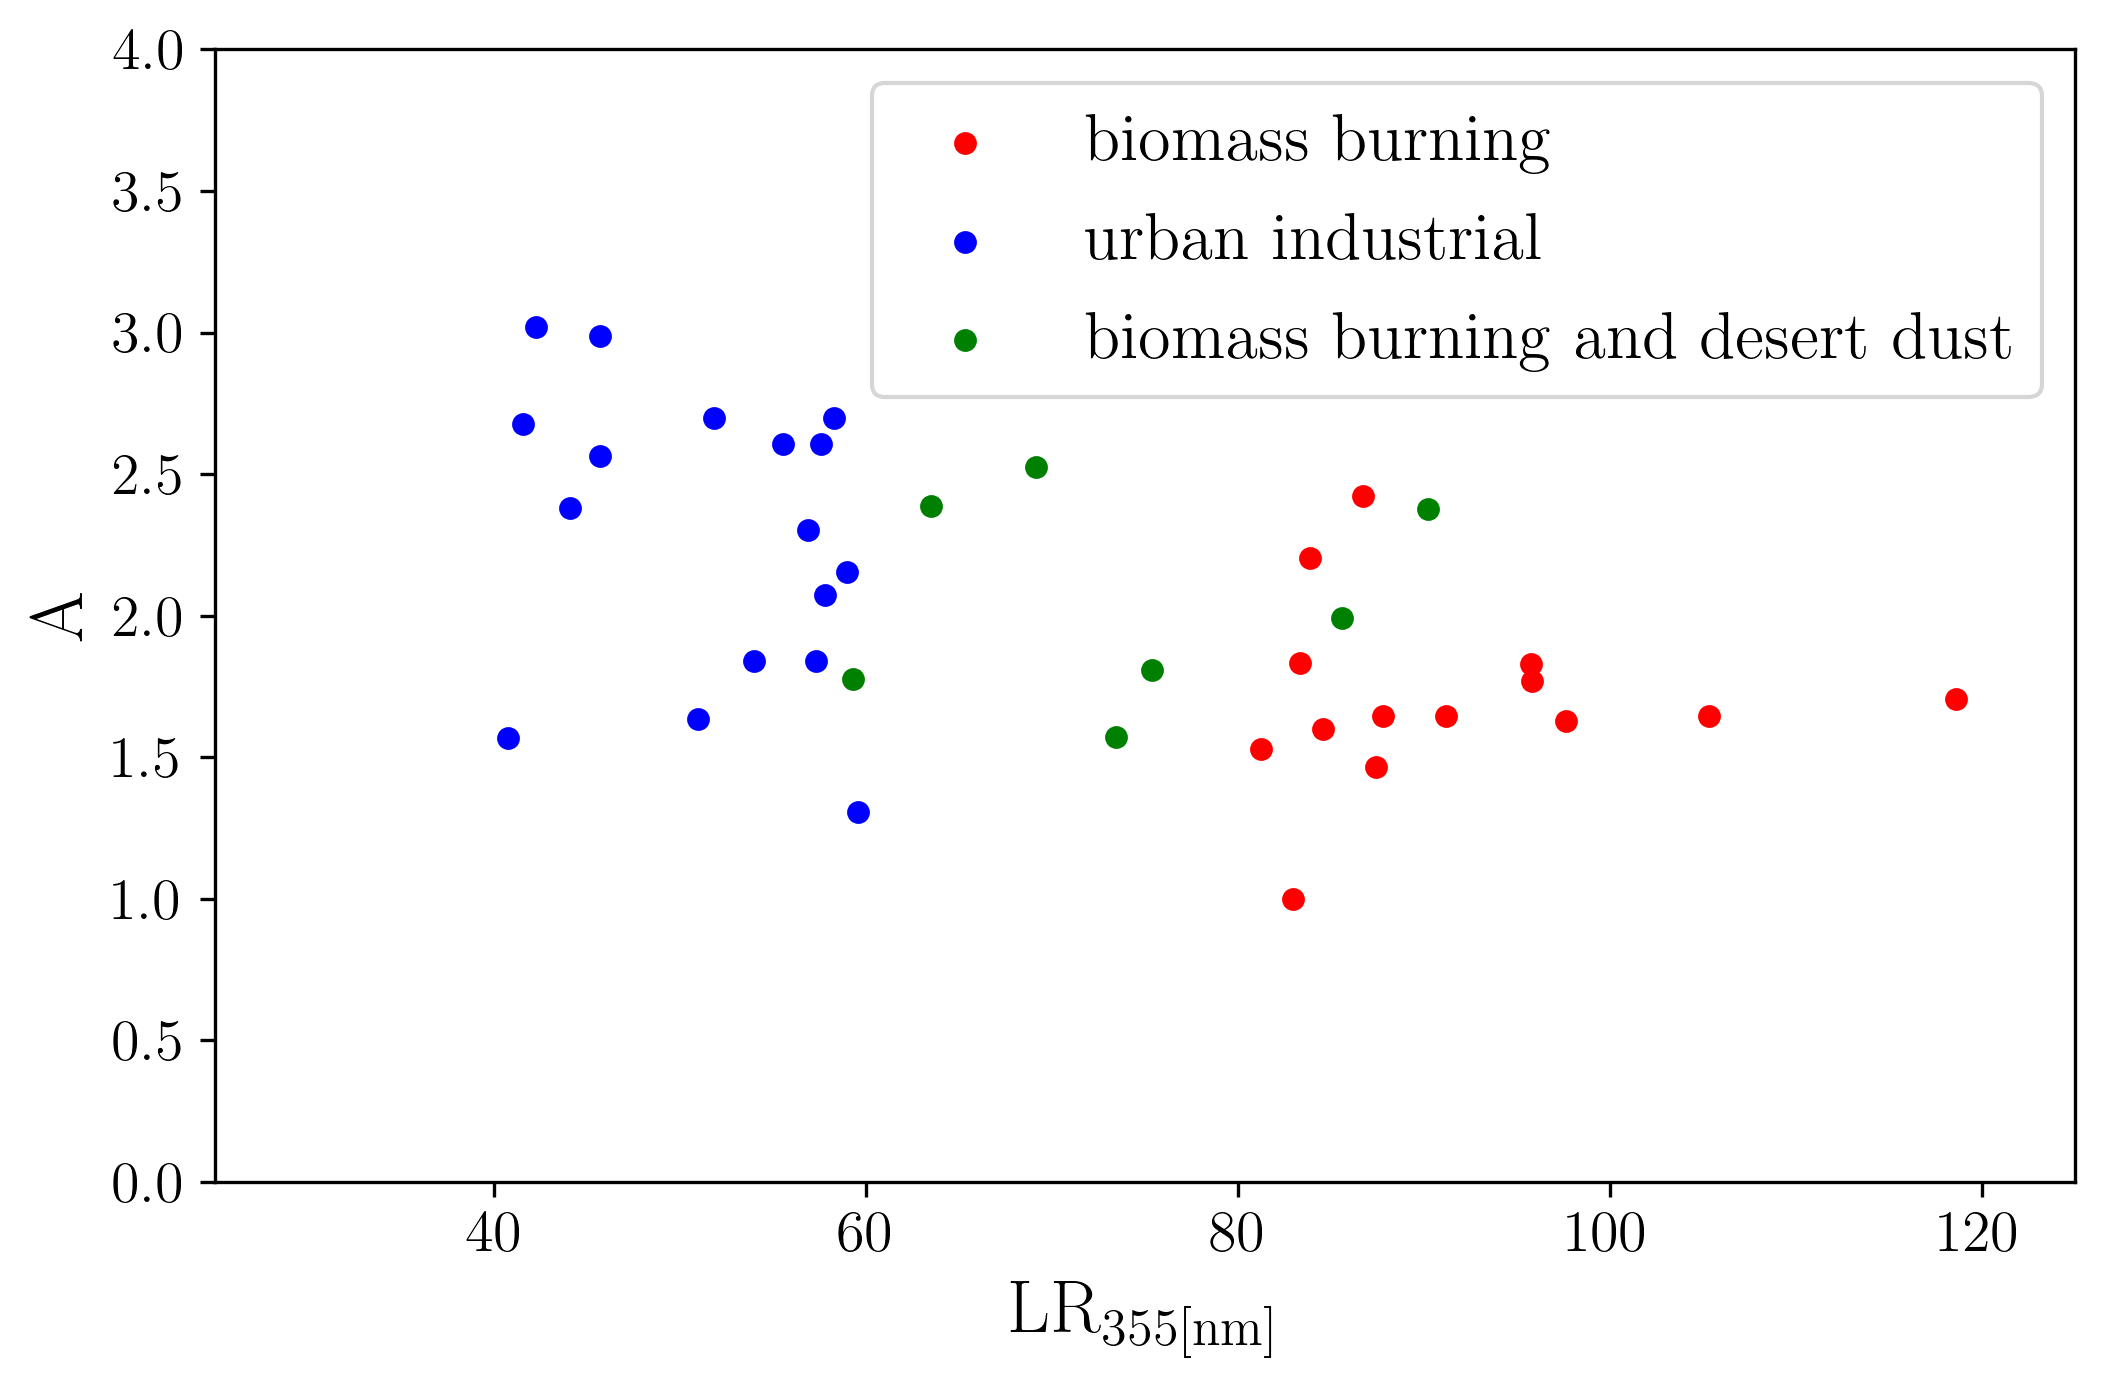

In [27]:
HOME_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir,os.pardir))
DATA_DIR = os.path.join(HOME_DIR,'data')
folder_name = os.path.join(DATA_DIR,'Angstrom_LidarRatio','plot_data')
csv_name = r'data_points_with_error_bars.csv'
df_A_LR = pd.read_csv(os.path.join(folder_name,csv_name))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (8,5))
df_A_LR[df_A_LR['type']=='red'].plot.scatter(x = 'x', y='y',label=df_A_LR[df_A_LR['type']=='red']['name'].unique()[0],c='r',ax=ax)
df_A_LR[df_A_LR['type']=='black'].plot.scatter(x = 'x', y='y',label=df_A_LR[df_A_LR['type']=='black']['name'].unique()[0],c='b',ax=ax)
df_A_LR[df_A_LR['type']=='green'].plot.scatter(x = 'x', y='y',label=df_A_LR[df_A_LR['type']=='green']['name'].unique()[0],c='g',ax=ax)
plt.xlabel(r'$\rm \, LR_{355[nm]}$')
plt.ylabel(r'$\rm A$')
plt.xlim([25, 125])
plt.ylim([0, 4])
plt.show()

### Creating joint probability $P(x=LR,y=A)$
1 . Calculating multivariate normal distribution for each type in the dataset

In [28]:
xmin,xmax = [25, 125]
ymin,ymax = [0, 4]
Z_types = []
weight_types  = []
for type in ['red','black','green']:
	df_type =  df_A_LR[df_A_LR['type']==type]
	LR_type = df_type['x']
	A_type = df_type['y']
	std_x =df_type['dx']*.5
	std_y =df_type['dy']*.5

	X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
	grid=np.dstack((X, Y))
	Z_type = np.zeros((grid.shape[0],grid.shape[1]))


	for x0,y0,stdx,stdy in zip(LR_type,A_type,std_x,std_y):
		cov = np.diag((stdx,stdy))
		rv = multivariate_normal((x0,y0), cov)
		Z_i=  np.reshape(rv.pdf(grid), X.shape)
		Z_type +=Z_i
	Z_types.append(Z_type)
	weight_types.append(len(df_type))

2 . Calculating the joint distribution by:
- Normalizing each to 1
- Weighted sum of distributions.
> Note: The weights are set according to the relative portion of the type in the original dataset.

Joint distribution according to the dataset

In [29]:
weights = np.array(weight_types)
weights= weights/weights.sum()
normal_Z = np.zeros((grid.shape[0],grid.shape[1]))
for z_type,weight in zip(Z_types,weights):
	normal_Z += weight*z_type/z_type.sum()

# Sampling the grid , with the weights set by the joint distribution inorder to generate a kernel distribution
xy = np.vstack([X.reshape(X.size), Y.reshape(Y.size)])
kernel_LR_A = stats.gaussian_kde(xy,weights =normal_Z.reshape(normal_Z.size) )
Z = np.reshape(kernel_LR_A(xy).T, X.shape)

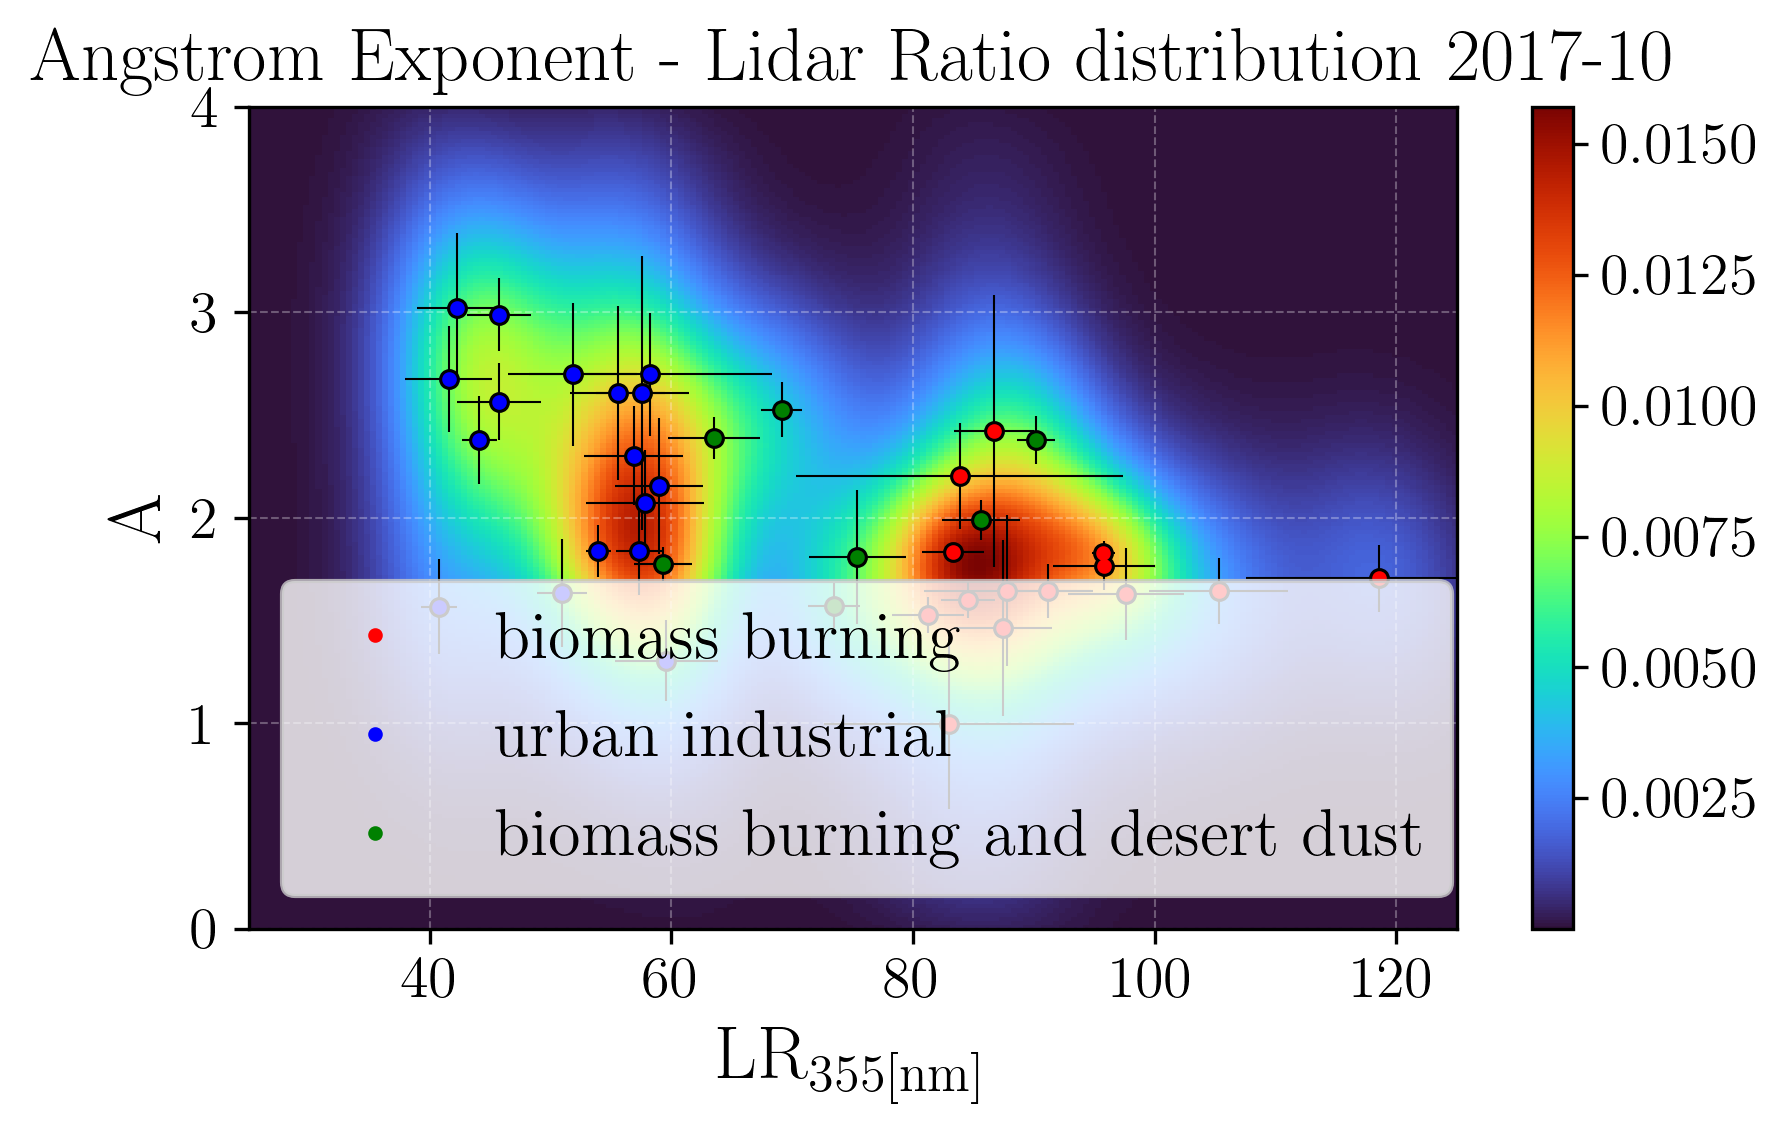

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.imshow(np.rot90(Z), cmap='turbo',
          extent=[xmin, xmax, ymin, ymax],aspect="auto")
for type in ['red','black','green']:
	x_type,y_type,label_type, x_err,y_err = df_A_LR[df_A_LR['type']==type]['x'],\
	                                       df_A_LR[df_A_LR['type']==type]['y'],\
	                                       df_A_LR[df_A_LR['type']==type]['name'].unique()[0],\
	                                       df_A_LR[df_A_LR['type']==type]['dx']*.5,\
	                                       df_A_LR[df_A_LR['type']==type]['dy']*.5
	ax.errorbar(x_type,y_type,xerr=x_err,yerr=y_err,  markersize=0, fmt='o',c='k',lw=.5)
	ax.plot(x_type,y_type, '.k', markersize=8)
	ax.plot(x_type,y_type, '.'+type[0], markersize=5,label=label_type)
ax.grid(color='w', linestyle='--', linewidth=0.5, alpha=0.3)
plt.xlabel(r'$\rm \, LR_{355[nm]}$')
plt.ylabel(r'$\rm A$')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
ax.set_title(f"Angstrom Exponent - Lidar Ratio distribution {t_slice.start.strftime('%Y-%m')}")
fig.colorbar(im, ax=ax)
plt.legend()
plt.tight_layout()
plt.show()

Joint distribution weighted in favor of urban industrial and desert dust

In [31]:
weights = np.array([.05,.75,.20])
normal_Z = np.zeros((grid.shape[0],grid.shape[1]))
for z_type,weight in zip(Z_types,weights):
	normal_Z += weight*z_type/z_type.sum()

# Sampling the grid , with the weights set by the joint distribution inorder to generate a kernel distribution
xy = np.vstack([X.reshape(X.size), Y.reshape(Y.size)])
kernel_LR_A = stats.gaussian_kde(xy,weights =normal_Z.reshape(normal_Z.size) )
Z = np.reshape(kernel_LR_A(xy).T, X.shape)

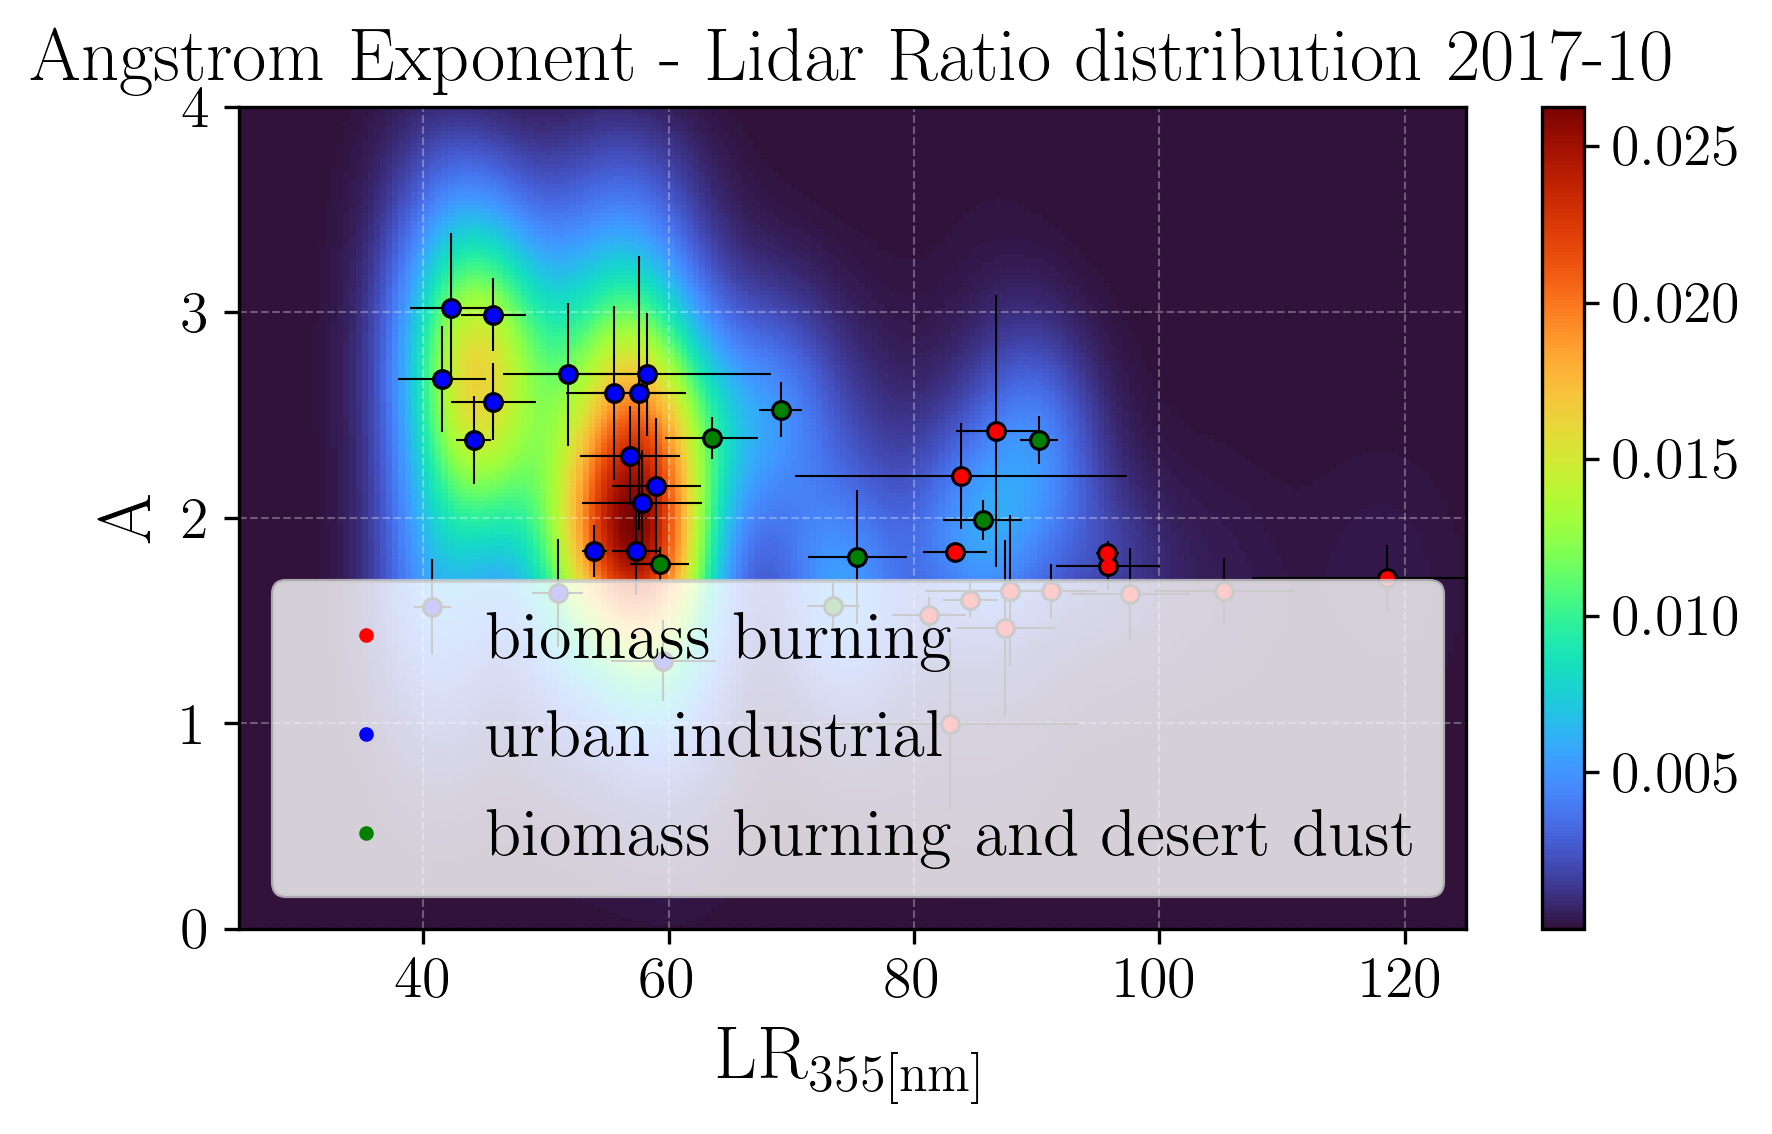

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.imshow(np.rot90(Z), cmap='turbo',
          extent=[xmin, xmax, ymin, ymax],aspect="auto")
for type in ['red','black','green']:
	x_type,y_type,label_type, x_err,y_err = df_A_LR[df_A_LR['type']==type]['x'],\
	                                       df_A_LR[df_A_LR['type']==type]['y'],\
	                                       df_A_LR[df_A_LR['type']==type]['name'].unique()[0],\
	                                       df_A_LR[df_A_LR['type']==type]['dx']*.5,\
	                                       df_A_LR[df_A_LR['type']==type]['dy']*.5
	ax.errorbar(x_type,y_type,xerr=x_err,yerr=y_err,  markersize=0, fmt='o',c='k',lw=.5)
	ax.plot(x_type,y_type, '.k', markersize=8)
	ax.plot(x_type,y_type, '.'+type[0], markersize=5,label=label_type)
ax.grid(color='w', linestyle='--', linewidth=0.5, alpha=0.3)
plt.xlabel(r'$\rm \, LR_{355[nm]}$')
plt.ylabel(r'$\rm A$')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
ax.set_title(f"Angstrom Exponent - Lidar Ratio distribution {t_slice.start.strftime('%Y-%m')}")
fig.colorbar(im, ax=ax)
plt.legend()
plt.tight_layout()
plt.show()

3. Sampling $LR$ from 1D conditioned probability $P(x=LR|y=A)$

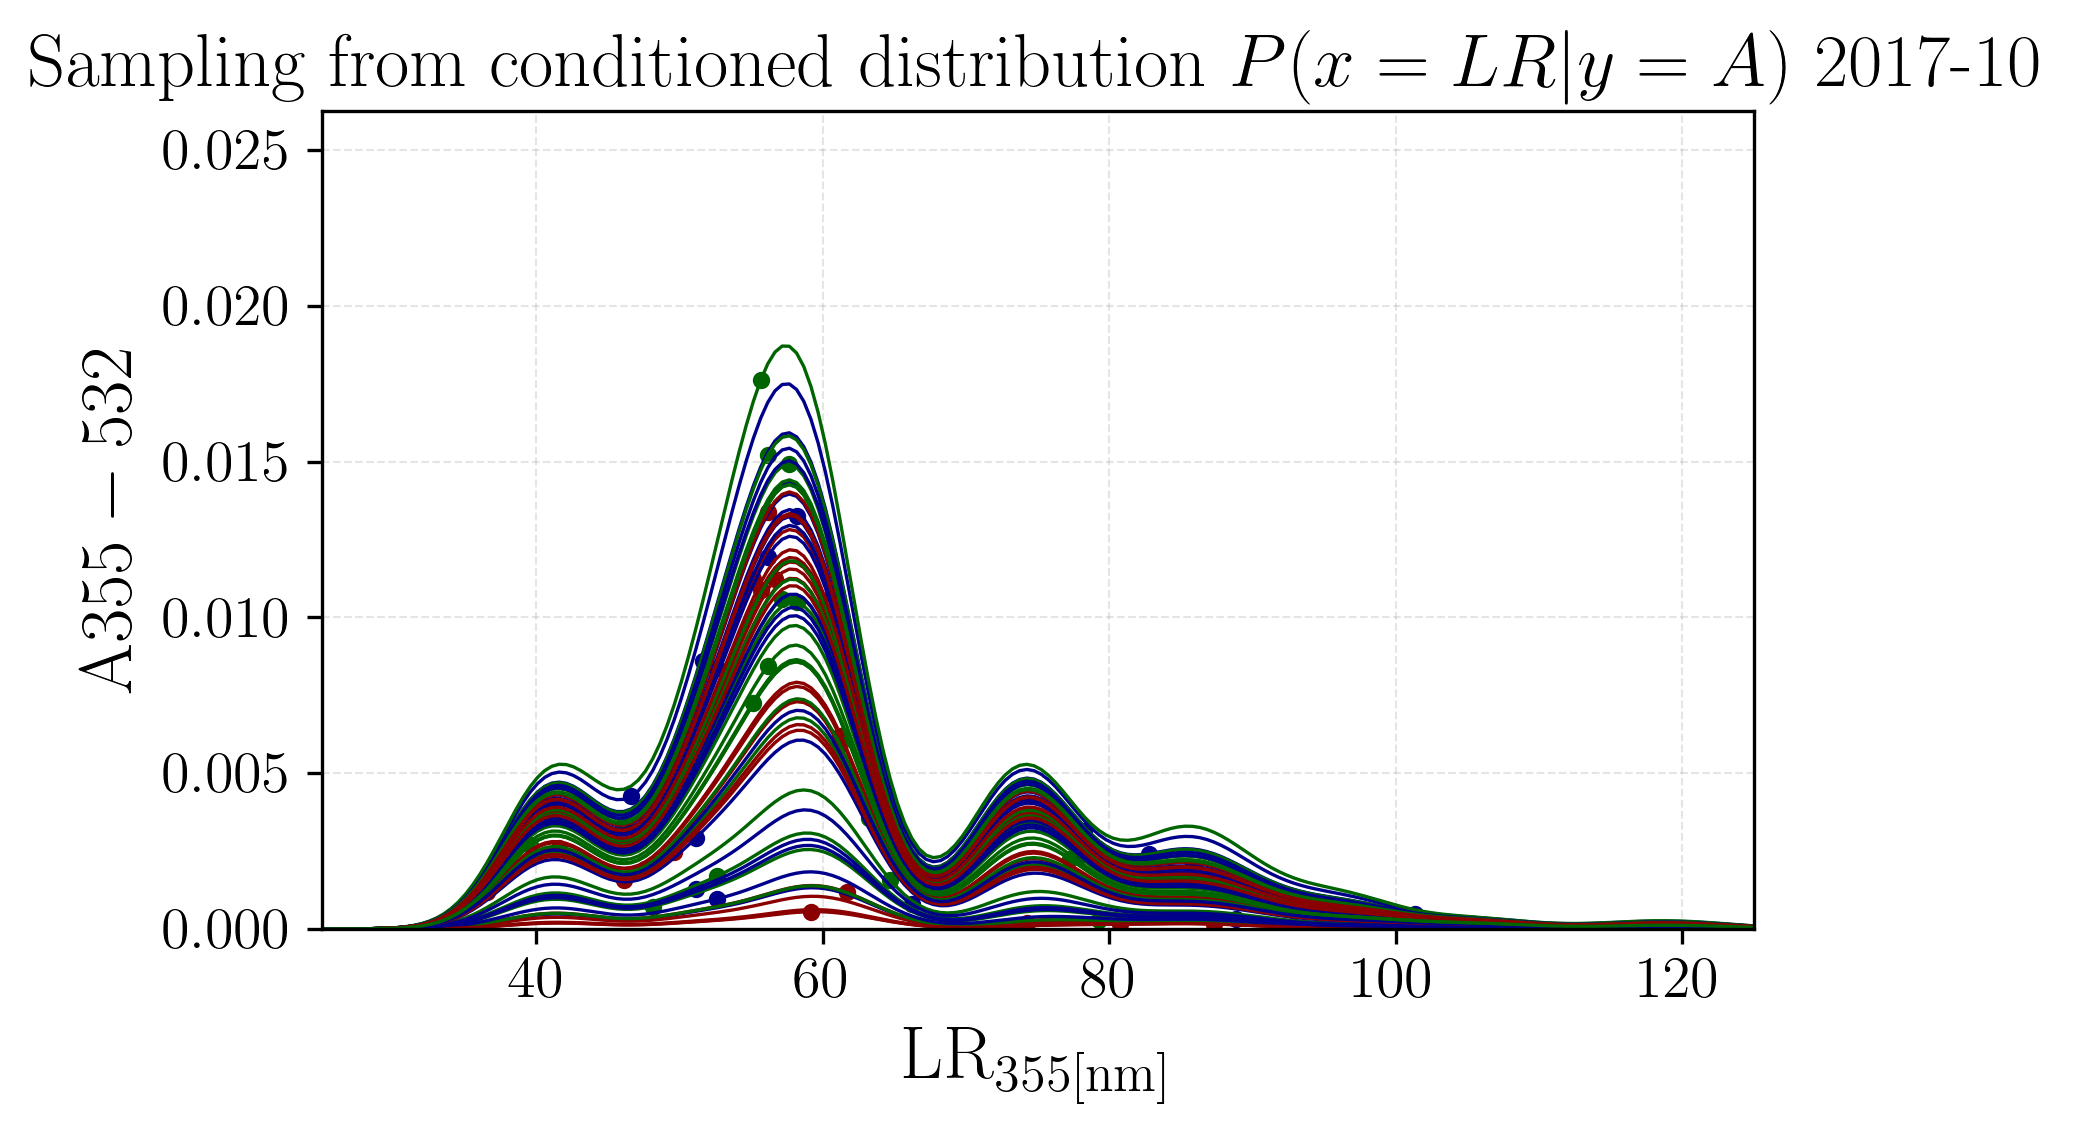

In [33]:
LR_samp = []
fig, ax = plt.subplots(nrows=1, ncols=1)
for ang in ang_355_532:
	# calc conditioned density for each value of Angstrom Exponent list
	X_, Y_ = np.mgrid[xmin:xmax:200j, ang:ang:1j]
	positions_ = np.vstack([X_.ravel(), Y_.ravel()])
	Z_ = np.reshape(kernel_LR_A(positions_).T, X_.shape)
	yy_i = Z_.reshape(Z_.size)
	xx_i = X_.reshape(X_.size)
	kernel_LR_cond_A_i = stats.gaussian_kde(yy_i)
	random_state = sns.utils.check_random_state(None)
	weights =  kernel_LR_cond_A_i.dataset[0,:]
	maxv = weights.max()
	minv = weights.min()
	weights= (weights-minv)/(maxv-minv)
	weights /=weights.sum()
	indx = random_state.choice(kernel_LR_cond_A_i.n, size=1, p=weights)
	ax.plot(xx_i,yy_i,linewidth =0.8)
	ax.scatter(x = xx_i[indx],y = yy_i[indx],s=10)
	LR_samp.append(xx_i[indx])
plt.xlabel(r'$\rm \, LR_{355[nm]}$')
plt.ylabel(r'$\rm A 355-532$')

ax.set_title(f"Sampling from conditioned distribution $P(x=LR|y=A)$ {t_slice.start.strftime('%Y-%m')}")
plt.tight_layout()
ax.grid(color='darkgray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.xlim([xmin,xmax])
plt.ylim([ymin,Z.max()])
plt.show()
plt.show()

LR_samp = np.array(LR_samp).reshape(2*monthdays)

4. Show the joint density, and the new samples of LR

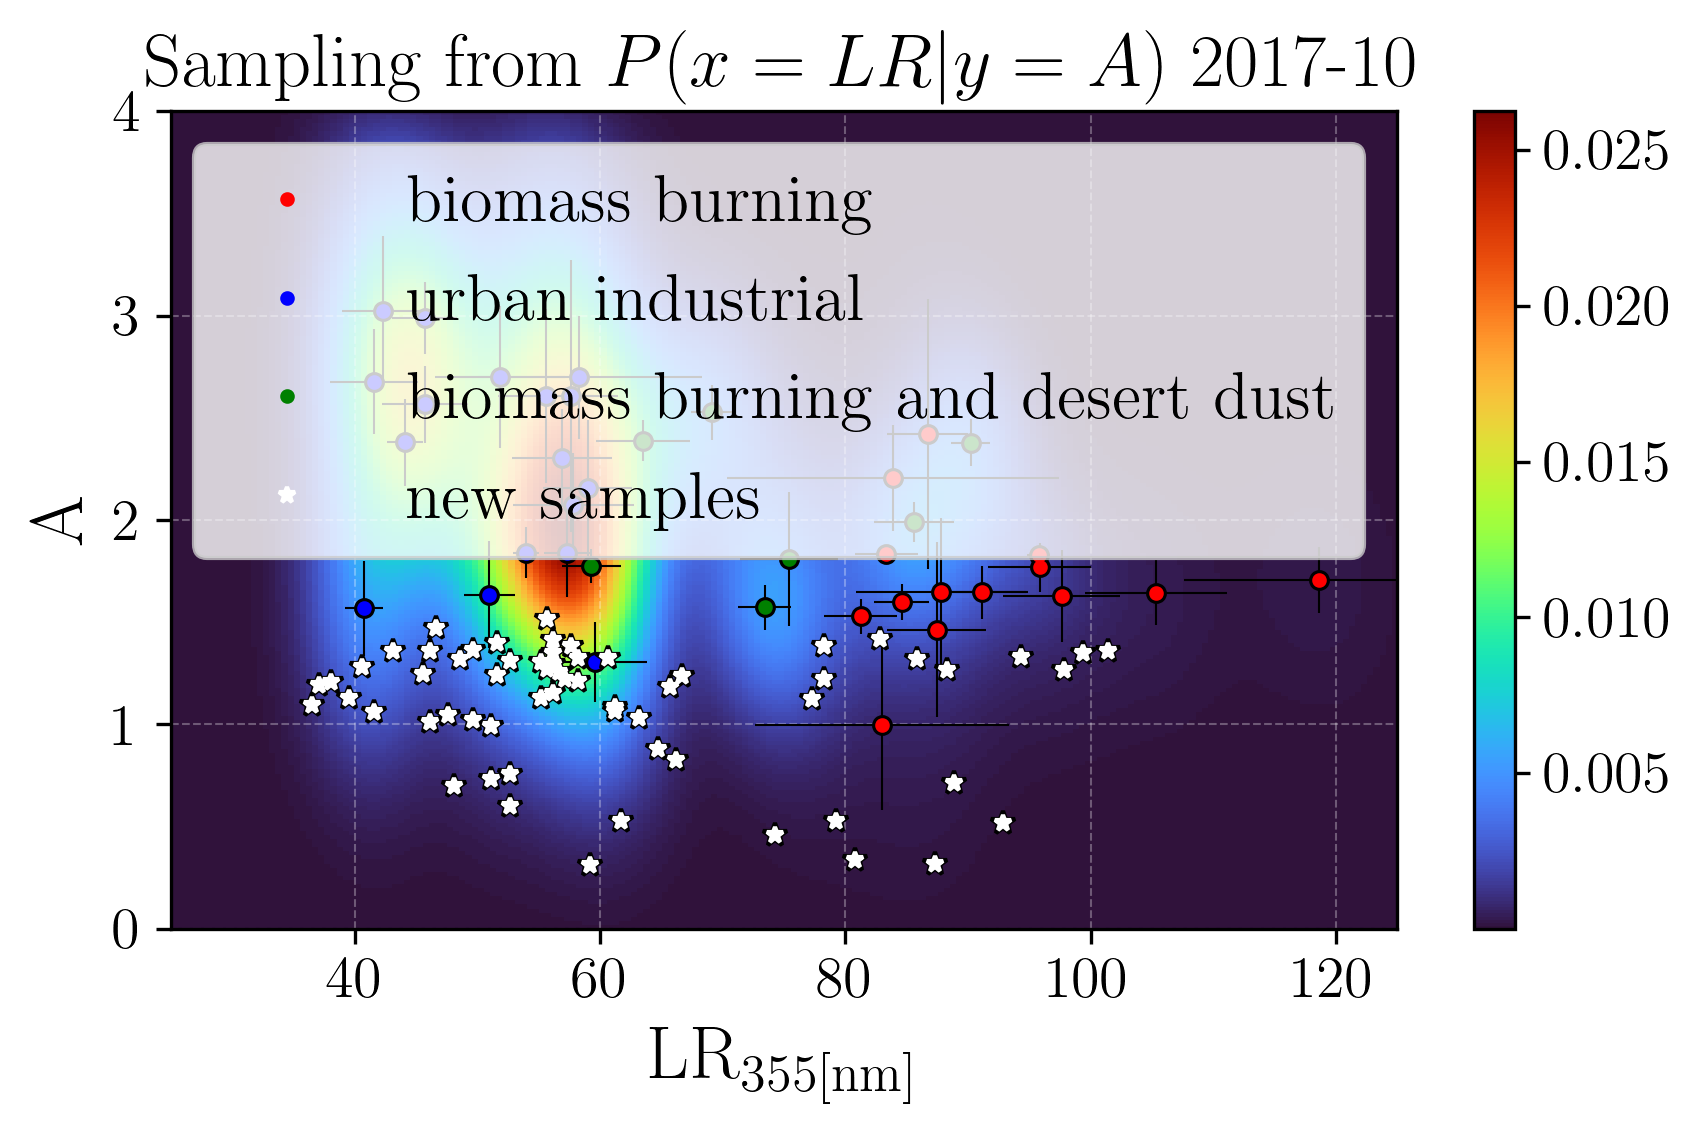

In [34]:
# Show density, and the new chosen samples
fig, ax = plt.subplots(nrows=1, ncols=1)
for type in ['red','black','green']:
	x_type,y_type,label_type, x_err,y_err = df_A_LR[df_A_LR['type']==type]['x'],\
	                                       df_A_LR[df_A_LR['type']==type]['y'],\
	                                       df_A_LR[df_A_LR['type']==type]['name'].unique()[0],\
	                                       df_A_LR[df_A_LR['type']==type]['dx']*.5,\
	                                       df_A_LR[df_A_LR['type']==type]['dy']*.5
	ax.errorbar(x_type,y_type,xerr=x_err,yerr=y_err,  markersize=0, fmt='o',c='k',lw=.5)
	ax.plot(x_type,y_type, '.k', markersize=8)
	ax.plot(x_type,y_type, '.'+type[0], markersize=5,label=label_type)
im = ax.imshow(np.rot90(Z), cmap='turbo',
          extent=[xmin, xmax, ymin, ymax],aspect="auto")
ax.plot(LR_samp,ang_355_532, 'k*', markersize=6)
ax.plot(LR_samp,ang_355_532, 'w*', markersize=4,label = 'new samples')
plt.xlabel(r'$\rm \, LR_{355[nm]}$')
plt.ylabel(r'$\rm A$')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
ax.set_title(f"Sampling from $P(x=LR|y=A)$ {t_slice.start.strftime('%Y-%m')}")
plt.legend()
fig.colorbar(im, ax=ax)
ax.grid(color='w', linestyle='--', linewidth=0.5, alpha=0.3)
plt.tight_layout()
plt.show()


### Sampling $r_m$ and $\beta_{532}^{max}$ for current month
1 . Load database relevant to current month

In [35]:
km_scale = 1E+3
start_date = datetime ( 2017 , 9 , 1 )
end_date = datetime ( 2017 , 10 , 31 )
csv_name = f"dataset_{station.name}_{start_date.strftime( '%Y-%m-%d' )}_{end_date.strftime ( '%Y-%m-%d' )}_extended.csv"
csv_path_extended = os.path.join(DATA_DIR,csv_name)
df_extended = pd.read_csv ( csv_path_extended )
df_extended['date'] = pd.to_datetime(df_extended['date'], format='%Y-%m-%d')
grps_month = df_extended.groupby(df_extended['date'].dt.month).groups
key_month  = month
df_month = df_extended.iloc[grps_month.get(key_month).values].reset_index()
rm = []
beta_532 = []
grps_files = df_month.groupby(df_month.profile_path).groups
for key,v in zip(grps_files.keys(),grps_files.values()):
    ds_profile = prep.load_dataset(key)
    max_beta_532 =  ds_profile.aerBsc_klett_532.values.max ( )
    max_beta_532 *= km_scale #  converting 1/(sr m) to  1/(sr km)
    cur_rm = df_month['rm'].iloc[v.values[0]]
    beta_532.append(max_beta_532)
    rm.append(cur_rm)

[2021-05-08 18:52:34,657] {C:\Users\addalin\Dropbox\Lidar\lidar_learning\learning_lidar\preprocessing\preprocessing.py:97} ERROR - 
Failed to load dataset file: H:\data_haifa\DATA FROM TROPOS\data\level1a\PollyXT_TROPOS\2017\10\01\2017_10_01_Sun_TROPOS_00_00_01_0034_0133_profiles.nc
Traceback (most recent call last):
  File "C:\Users\addalin\.conda\envs\lidar\lib\site-packages\xarray\backends\file_manager.py", line 199, in _acquire_with_cache_info
    file = self._cache[self._key]
  File "C:\Users\addalin\.conda\envs\lidar\lib\site-packages\xarray\backends\lru_cache.py", line 53, in __getitem__
    value = self._cache[key]
KeyError: [<class 'netCDF4._netCDF4.Dataset'>, ('H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\10\\01\\2017_10_01_Sun_TROPOS_00_00_01_0034_0133_profiles.nc',), 'r', (('clobber', True), ('diskless', False), ('format', 'NETCDF4'), ('persist', False))]

During handling of the above exception, another exception occurred:

Traceback (most recent c

FileNotFoundError: [Errno 2] No such file or directory: b'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\10\\01\\2017_10_01_Sun_TROPOS_00_00_01_0034_0133_profiles.nc'

2 . Estimate kernel density for $r_{m}$ vs. $\beta_{532}^{max}$

In [ ]:
df_rm_beta = pd.DataFrame(columns = ['rm','beta-532'], data = np.array([rm,beta_532]).T)
# Remove irrelevant values
index_to_remove = df_rm_beta[(df_rm_beta['beta-532'] > 1.0) | (df_rm_beta['beta-532'] < 0.0)].index
df_rm_beta.drop(index=index_to_remove,inplace=True)

fig, ax = plt.subplots(nrows=1, ncols=1)
df_rm_beta.plot.scatter(x='rm',y='beta-532',ax = ax,s = 10)
x =df_rm_beta['rm'].T
y = df_rm_beta['beta-532'].T
xmin,xmax = [x.min(),x.max()]
ymin,ymax = [y.min(),y.max()]
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.show()

3. Sample new values for  $r_{m}$ , $\beta_{532}^{max}$ per each day

In [ ]:
# Estimate kernel
values = np.vstack([x, y])

kernel_rm_beta = stats.gaussian_kde(values)

# Sample new points
rm_bounds = [np.round_(df_rm_beta['rm'].min()),
             np.ceil(df_rm_beta['rm'].max())]
beta_bounds = [0.0, 1.0]

rm_v = []
beta_v =[]
for day in range(monthdays):
	VALID_DOMAIN= False
	while (~VALID_DOMAIN) :
		sample_rm,sample_beta = kernel_rm_beta.resample(1)[:,0]
		VALID_DOMAIN = valid_box_domain(sample_rm,sample_beta,
                                        rm_bounds,beta_bounds)
	rm_v.append(sample_rm)
	beta_v.append(sample_beta)
rm_v,beta_v
rm_new,beta_532_new = np.array(rm_v),np.array(beta_v)
#x_,y_ = kernel_rm_beta.resample(monthdays+10)
#scores_new = kernel_rm_beta([x_, y_])
#max_ind = np.argpartition(scores_new, -monthdays)[-monthdays:]
#rm_new,beta_532_new = x_[max_ind],y_[max_ind]

# Calc 2D function of the density
xmin,xmax = [min(x.min(),rm_new.min()),max(x.max(),rm_new.max())]
ymin,ymax = [min(y.min(),beta_532_new.min()),max(y.max(),beta_532_new.max())]
X, Y = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]
xy = np.vstack([X.reshape(X.size), Y.reshape(Y.size)])
Z = np.reshape(kernel_rm_beta(xy).T, X.shape)
# %%

# Show density and the new chosen samples
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (8,5))
df_rm_beta.plot.scatter(x='rm',y='beta-532',ax = ax,c='k')
im = ax.imshow(np.rot90(Z), cmap='turbo',
          extent=[xmin, xmax, ymin, ymax],aspect="auto")
ax.plot(rm_new,beta_532_new, 'k*', markersize=6)
ax.plot(rm_new,beta_532_new, 'w*', markersize=4,label = 'new samples')
ax.set_xlabel(r'$r_m$')
ax.set_ylabel(r'$\beta_{532}^{max}$')
ax.set_title(r"Sampling from $r_m$ - $ \beta_{532}^{max}$  "+f"{t_slice.start.strftime('%Y-%m')}")
fig.colorbar(im, ax=ax)
plt.legend()
plt.tight_layout()
plt.show()

Create datase of parameters for generating month signals

rm_new,beta_532_new, LR_samp,ang_355_532, ang_532_1064

In [ ]:
# resizing beta and rm
listr= [[r,r] for r in rm_new]
rm_new = np.array(listr).reshape(monthdays*2)
listb= [[b,b] for b in beta_532_new]
beta_532_new = np.array(listb).reshape(monthdays*2)
# %%
start_day = datetime(year,month,1,0,0)
end_day = datetime(year,month,monthdays,0,0)
days = pd.date_range(start_day,end_day+timedelta(hours = 12),freq = '12H')
ds_month = xr.Dataset ( data_vars = {'rm' : (('Time') , rm_new) ,
                                   'ang355532' : (('Time') , ang_355_532) ,
                                   'ang5321064' : (('Time') , ang_532_1064) ,
                                   'LR' : (('Time')  , LR_samp) ,
                                   'beta532' : (('Time') ,beta_532_new)} ,
                      coords = {'Time' : days.values })

ds_month = ds_month.assign(aeronet_source = xr.Variable(dims=(),data=os.path.join(station.aeronet_folder,nc_aeronet_name),
                             attrs={'info':'netcdf file name, processed from AERONET retrievals,'
                                           ' using: read_AERONET_data.py.'}))
ds_month.rm.attrs = {'units' : r'$km$' , 'long_name' : r'$r_m$' ,
                   'info' : 'Reference range'}
ds_month.ang355532.attrs = { 'long_name' : r'$\AA_{355,532}$' ,
                         'info' : 'Angstrom Exponent 355,532'}
ds_month.ang5321064.attrs = {'long_name' : r'$\AA_{532,1064}$' ,
                         'info' : 'Angstrom Exponent 532,1064'}
ds_month.LR.attrs = {'units' : r'$sr$' , 'long_name' : r'$LR$' ,
                     'info' : 'Lidar Ratio'}
ds_month.beta532.attrs = {'units' : r'$km^{{-1}} sr^{-1}$'  ,
                          'long_name' : r'$\beta$' ,
                          'info' : '$Aerosol Backscatter'}

save the dataset

In [ ]:
SAVE_DS  = False
if SAVE_DS:
    gen_source_path = gen_utils.get_month_gen_params_path(station, start_day,type='density_params')
    print(gen_source_path)
    prep.save_dataset ( ds_month , os.path.dirname(gen_source_path) ,
                        os.path.basename(gen_source_path) )

#### 6. Converting Bezier paths to LC(t) and creating dataset of generated lidar power.

In [ ]:
# Set the period for calculating bezier fitting
start_time = start_day
end_time = end_day + timedelta(days = 1)# - timedelta(seconds = 30) #start_time +timedelta(hours=freq_H)# final_dt# datetime(2017,10,31)
tslice = slice(start_time,end_time)
p_slice = ds_month.ang355532.sel(Time = tslice)
n_pts = p_slice.Time.size
t0 = p_slice.Time[0].values
t1 = p_slice.Time[-1].values
dt0 = prep.dt64_2_datetime(t0)
dt1 = prep.dt64_2_datetime(t1)
difft = (end_time-start_time)

In [ ]:
n_total  = difft.days*station.total_time_bins + difft.seconds/station.freq
dn_t = np.int(n_total/(n_pts))
# initialize the points at times of n_pts
points = np.empty((n_pts+1,2))
points[:,0] = np.array([n*dn_t for n in range(n_pts+1)])
points[0:monthdays*2,1] = p_slice.values
points[-1,1] = p_slice.values[-1]
# calc bezier
path_ang355532 = Bezier.evaluate_bezier(points, int(dn_t))

In [ ]:
# Set the time index in which the interpolation is calculated.
time_index=pd.date_range(start = start_date, end = end_time,freq = f'30S')
ds_bezier = xr.Dataset (
data_vars = {'ang355532' : (('Time') , path_ang355532[0:-1,1])} ,
coords = {'Time' : time_index.values[0:-1] })

In [ ]:
ds_bezier.ang355532.plot()
ds_month.plot.scatter(x='Time',y='ang355532')
plt.show()